In [1]:
import os.path
import json
import matplotlib
import pandas as pd
import requests
from ebi_eva_internal_pyutils.metadata_utils import get_metadata_connection_handle
from ebi_eva_internal_pyutils.pg_utils import get_all_results_for_query
from requests import HTTPError

/Users/tcezard/PycharmProjects/eva-tasks/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Daily and Yearly plot for FTP and WEB traffic

In [2]:
private_config_xml_file = 'maven_settings.xml'
query_ftp = '''select event_ts, uhost,  file_name, file_size
           from eva_web_srvc_stats.ftp_traffic
           where file_size>0;'''

with get_metadata_connection_handle('production_processing', private_config_xml_file) as db_conn:
    all_ftp_df = pd.DataFrame(get_all_results_for_query(db_conn, query_ftp), columns =['event_ts', 'uhost', 'file_name', 'file_size'])

raw_ftp_df_daily = all_ftp_df.groupby(all_ftp_df.event_ts.dt.date).agg(
    file_size=pd.NamedAgg(column='file_size', aggfunc='sum'),
    uhost=pd.NamedAgg(column='uhost', aggfunc='nunique'),
    nb_request=pd.NamedAgg(column='uhost', aggfunc='count'))
raw_ftp_df_daily.reset_index(inplace=True)
raw_ftp_df_daily['year']=pd.DatetimeIndex(raw_ftp_df_daily.event_ts).year
raw_ftp_df_daily['month']=pd.to_datetime(raw_ftp_df_daily.event_ts).dt.strftime('%Y-%m')

In [3]:
query_web = '''select request_ts, client_ip, bytes_out
               from eva_web_srvc_stats.ws_traffic_useful_cols'''
with get_metadata_connection_handle('production_processing', private_config_xml_file) as db_conn:
    all_web_df = pd.DataFrame(get_all_results_for_query(db_conn, query_web), columns =['request_ts', 'client_ip', 'bytes_out'])
raw_web_df_daily = all_web_df.groupby(all_web_df.request_ts.dt.date).agg(
    bytes_out=pd.NamedAgg(column='bytes_out', aggfunc=lambda x: sum(x)/1000000000),
    unique_ip=pd.NamedAgg(column='client_ip', aggfunc='nunique'),
    nb_request=pd.NamedAgg(column='client_ip', aggfunc='count'))
raw_web_df_daily.reset_index(inplace=True)
raw_web_df_daily['year']=pd.DatetimeIndex(raw_web_df_daily.request_ts).year
raw_web_df_daily['month']=pd.to_datetime(raw_web_df_daily.request_ts).dt.strftime('%Y-%m')

In [4]:
def draw_box_plot(dataframe, column, group, xlabel, ylabel, x_rotation=0, fig_size=(7, 7), fontsize=16):
    ax = dataframe.boxplot(column, by=group, widths=0.9, color=dict(boxes='k', whiskers='k', medians='k', caps='k'),
                           medianprops=dict(linewidth=2, color='k'), grid=False, showfliers=False, showcaps=False, figsize=fig_size)
    ax.spines[['right', 'top']].set_visible(False)
    fig = ax.get_figure()
    fig.suptitle('')
    ax.tick_params(axis='x', rotation=x_rotation)
    ax.set_title('')
    ax.set_facecolor('white')
    ax.spines['bottom'].set_color('k')
    ax.spines['left'].set_color('k')
    ax.tick_params(axis='x', which='both', colors='k')
    ax.tick_params(axis='y', which='both', colors='k')

    ax.set_ylabel(ylabel, fontdict={'fontsize':fontsize})
    ax.set_xlabel(xlabel, fontdict={'fontsize':fontsize})
    ax.tick_params(axis='x', labelsize=fontsize-4)
    ax.tick_params(axis='y', labelsize=fontsize-4)
    return ax, fig

In [5]:
current_year_range = (2017,2018,2019,2020,2021,2022,2023)
all_ftp_df_daily = raw_ftp_df_daily[raw_ftp_df_daily['year'].isin( current_year_range )]
all_web_df_daily = raw_web_df_daily[raw_web_df_daily['year'].isin( current_year_range )]

## Number of daily FTP download request per year and month

## IP address connected to EVA in 2023

## Connection to EVA

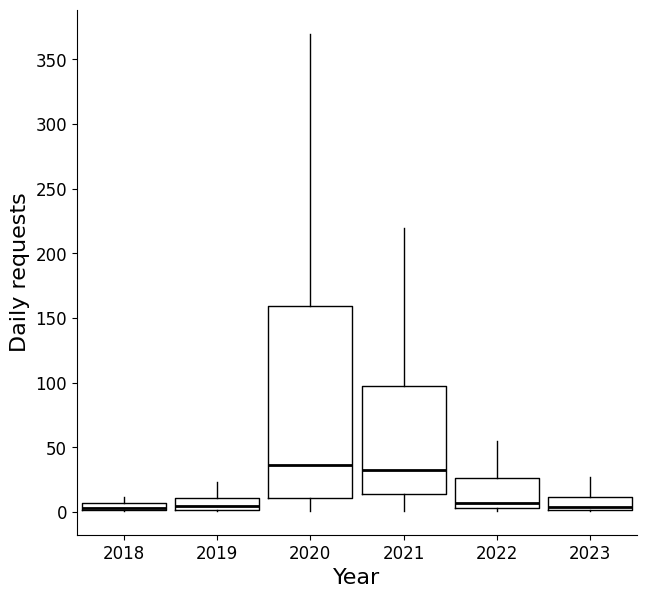

In [6]:
ax, fig=draw_box_plot(all_ftp_df_daily, 'nb_request', 'year', xlabel='Year', ylabel='Daily requests')

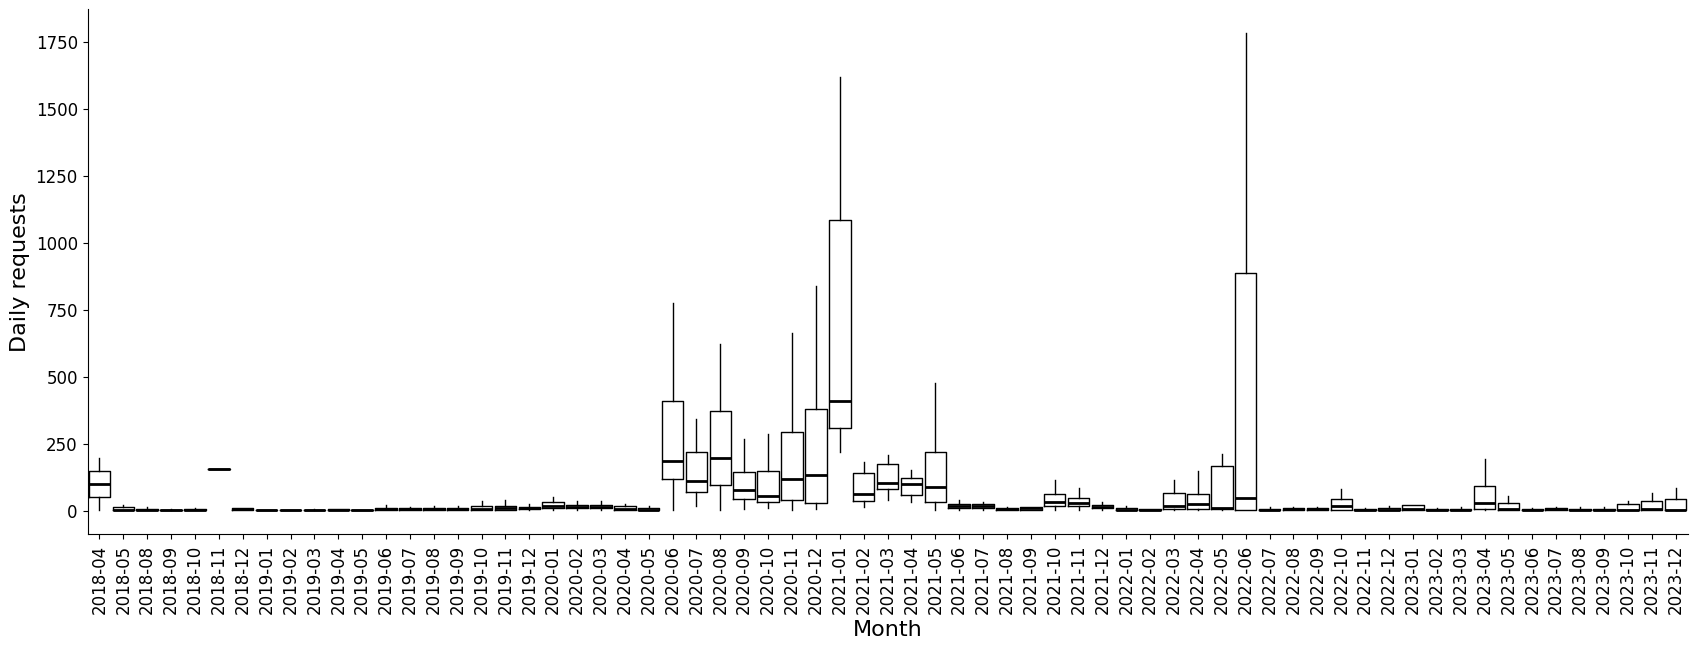

In [7]:
ax, fig=draw_box_plot(all_ftp_df_daily, 'nb_request', 'month', xlabel='Month', ylabel='Daily requests', x_rotation=90, fig_size=(20, 7))

## Number of daily FTP unique visitor per year and month

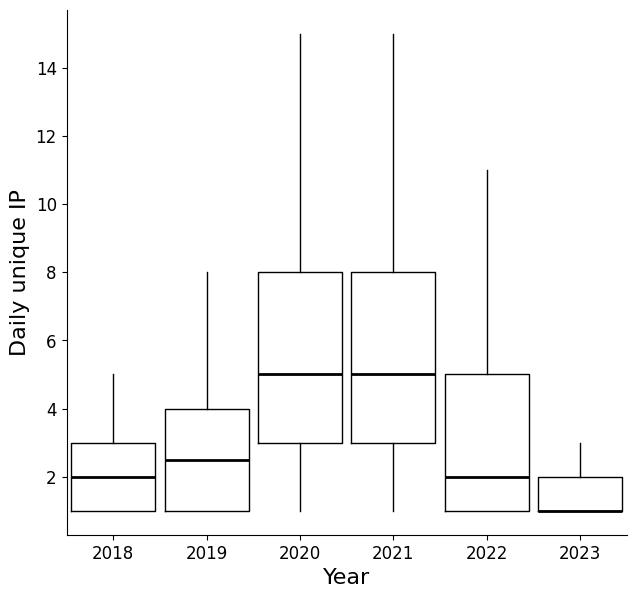

In [8]:
ax, fig=draw_box_plot(all_ftp_df_daily, 'uhost', 'year', xlabel='Year', ylabel='Daily unique IP')

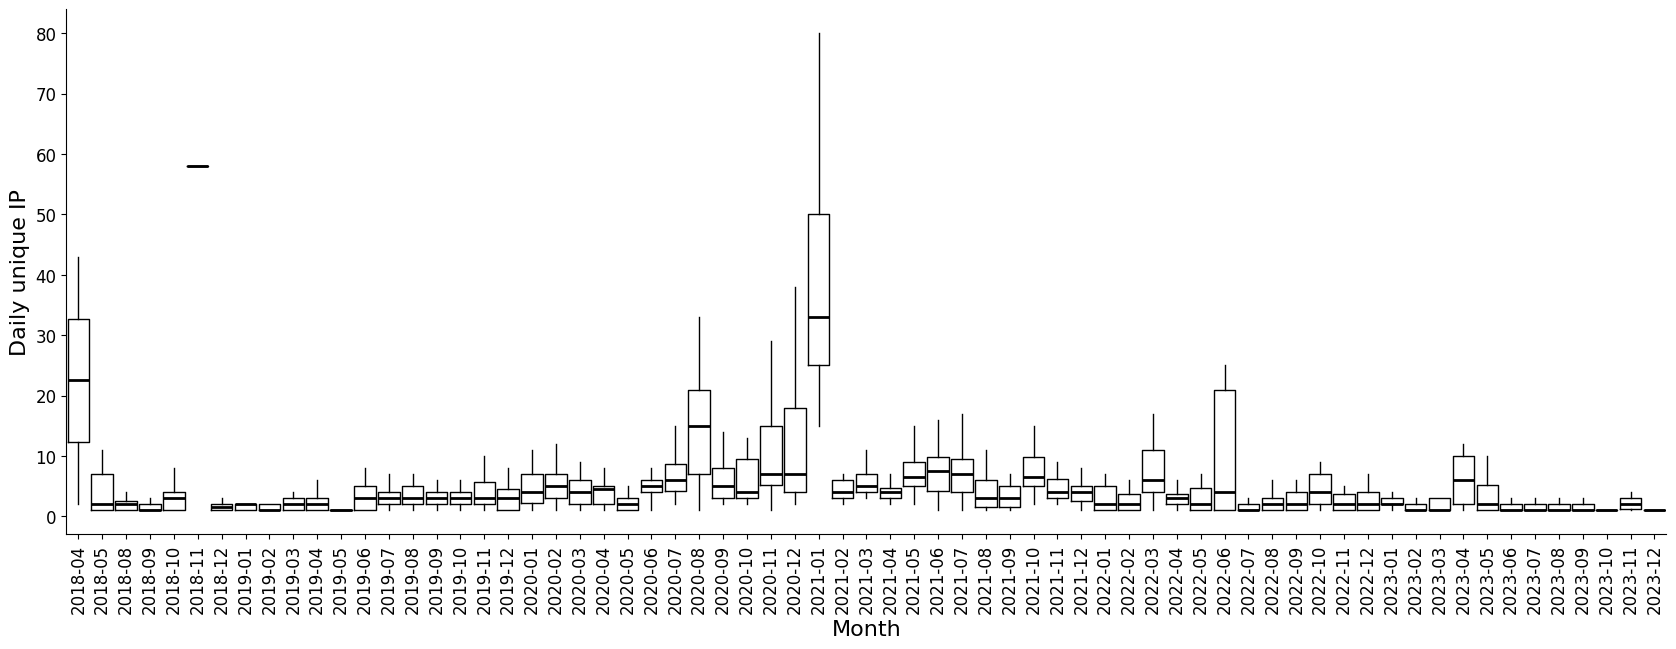

In [9]:
ax, fig=draw_box_plot(all_ftp_df_daily, 'uhost', 'month', xlabel='Month', ylabel='Daily unique IP', x_rotation=90, fig_size=(20, 7))

## Number of daily FTP download amount per year and month

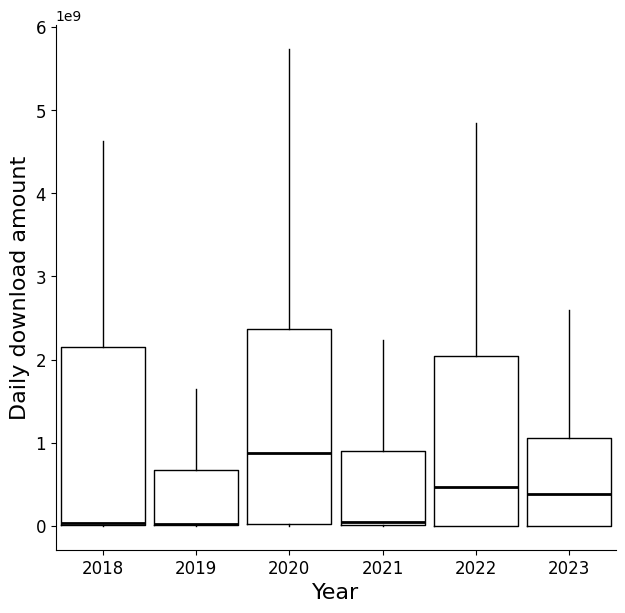

In [10]:
ax, fig=draw_box_plot(all_ftp_df_daily, 'file_size', 'year', xlabel='Year', ylabel='Daily download amount')

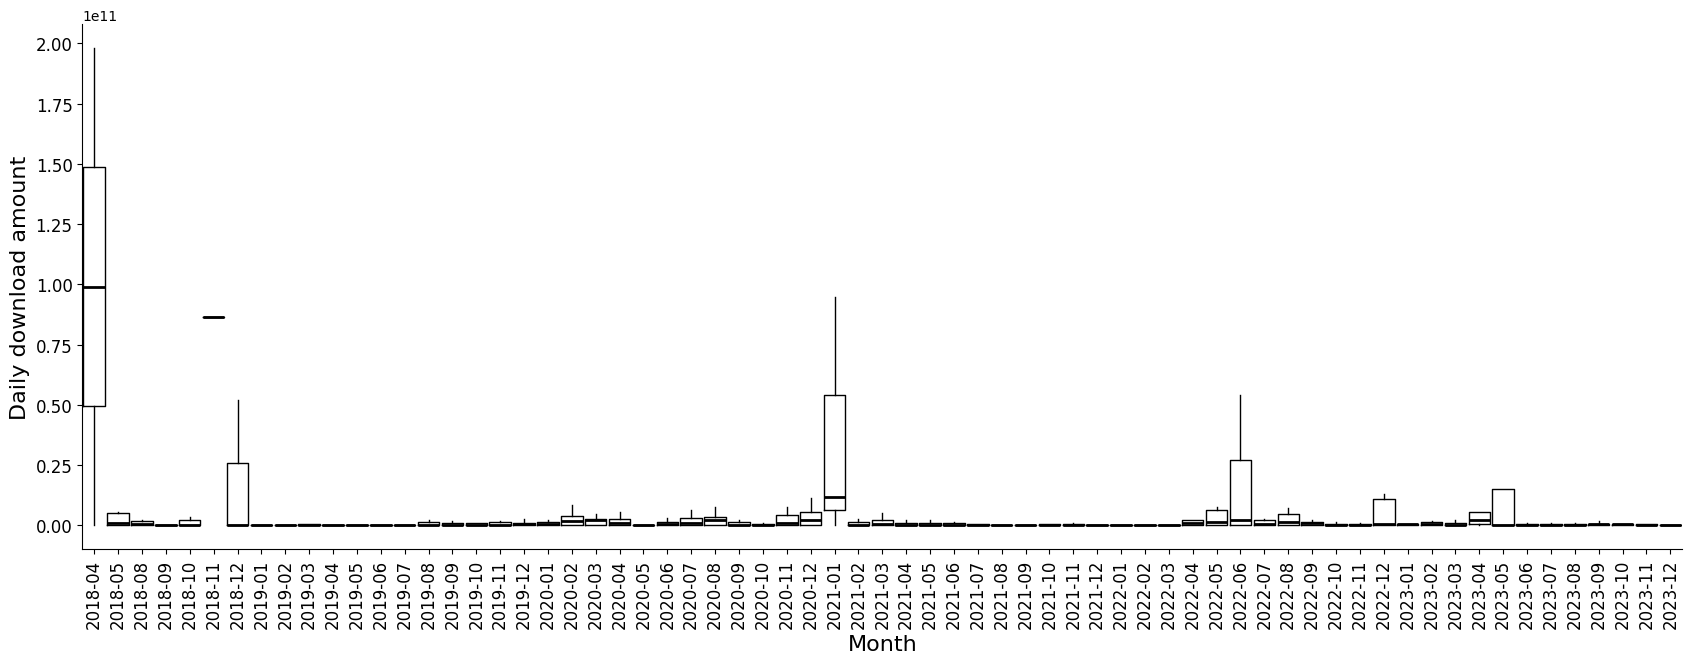

In [11]:
ax, fig=draw_box_plot(all_ftp_df_daily, 'file_size', 'month', xlabel='Month', ylabel='Daily download amount', x_rotation=90, fig_size=(20, 7))

## Number of daily web request per year and month

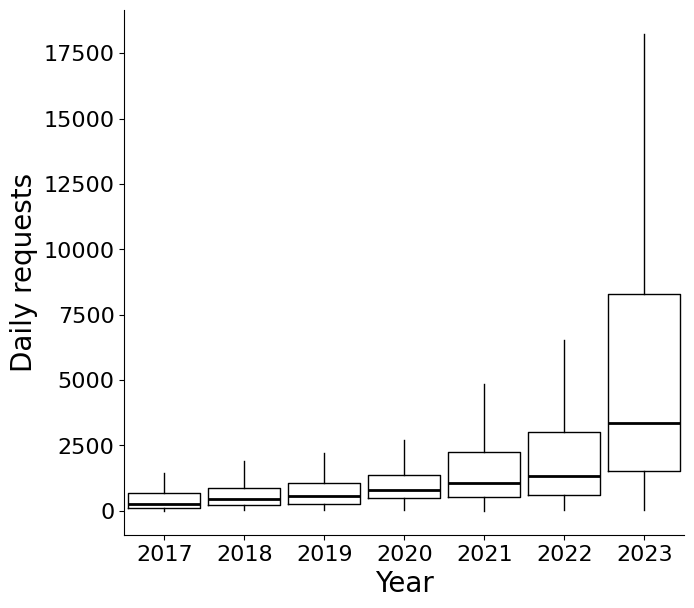

In [12]:
ax, fig=draw_box_plot(all_web_df_daily, 'nb_request', 'year', xlabel='Year', ylabel='Daily requests', fontsize=20)

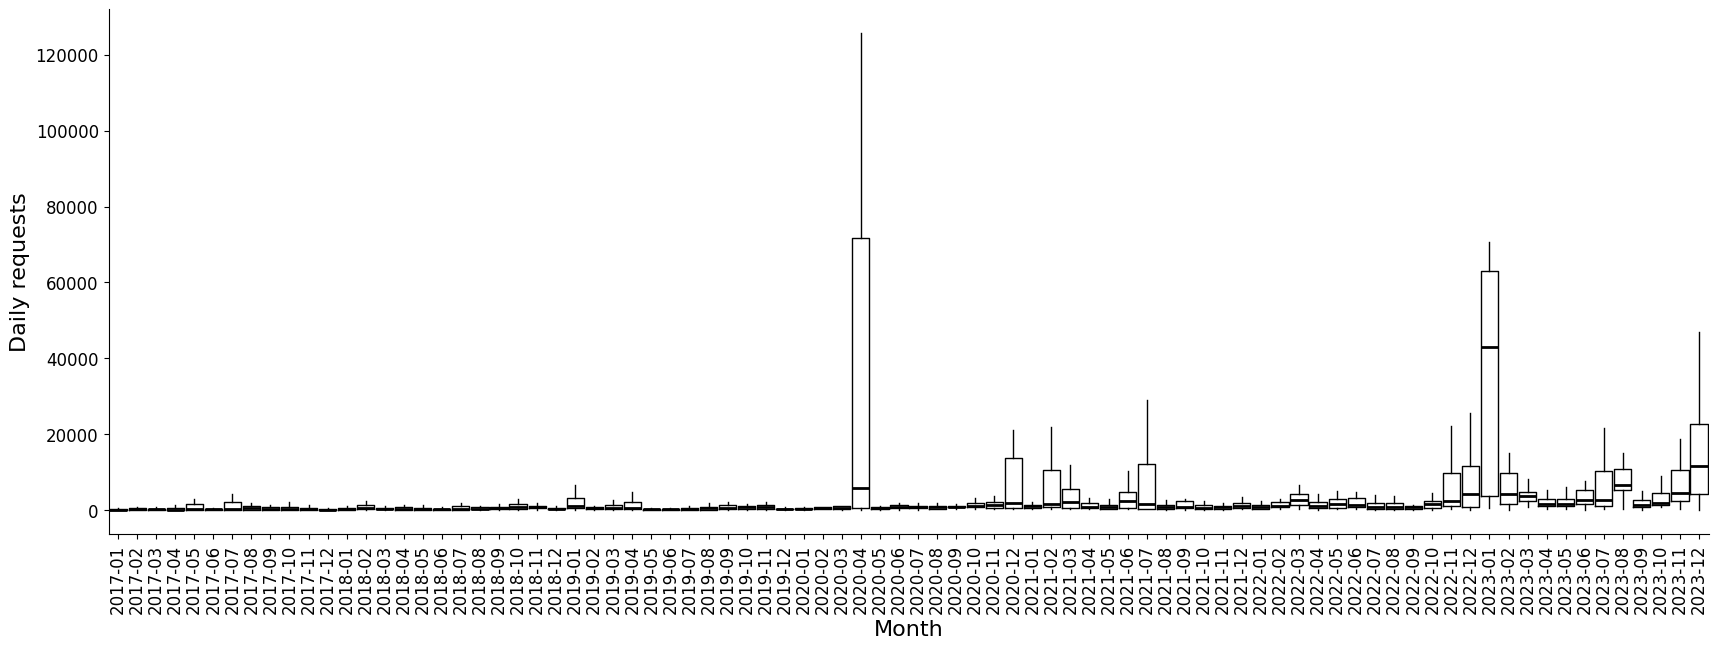

In [13]:
ax, fig=draw_box_plot(all_web_df_daily, 'nb_request', 'month', xlabel='Month', ylabel='Daily requests', x_rotation=90, fig_size=(20, 7))

## Number of daily web unique visitor per year and month

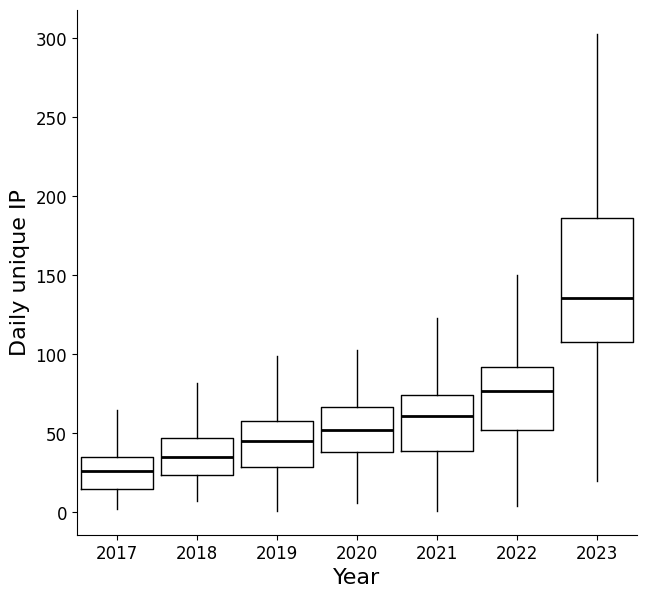

In [14]:
ax, fig=draw_box_plot(all_web_df_daily, 'unique_ip', 'year', xlabel='Year', ylabel='Daily unique IP')

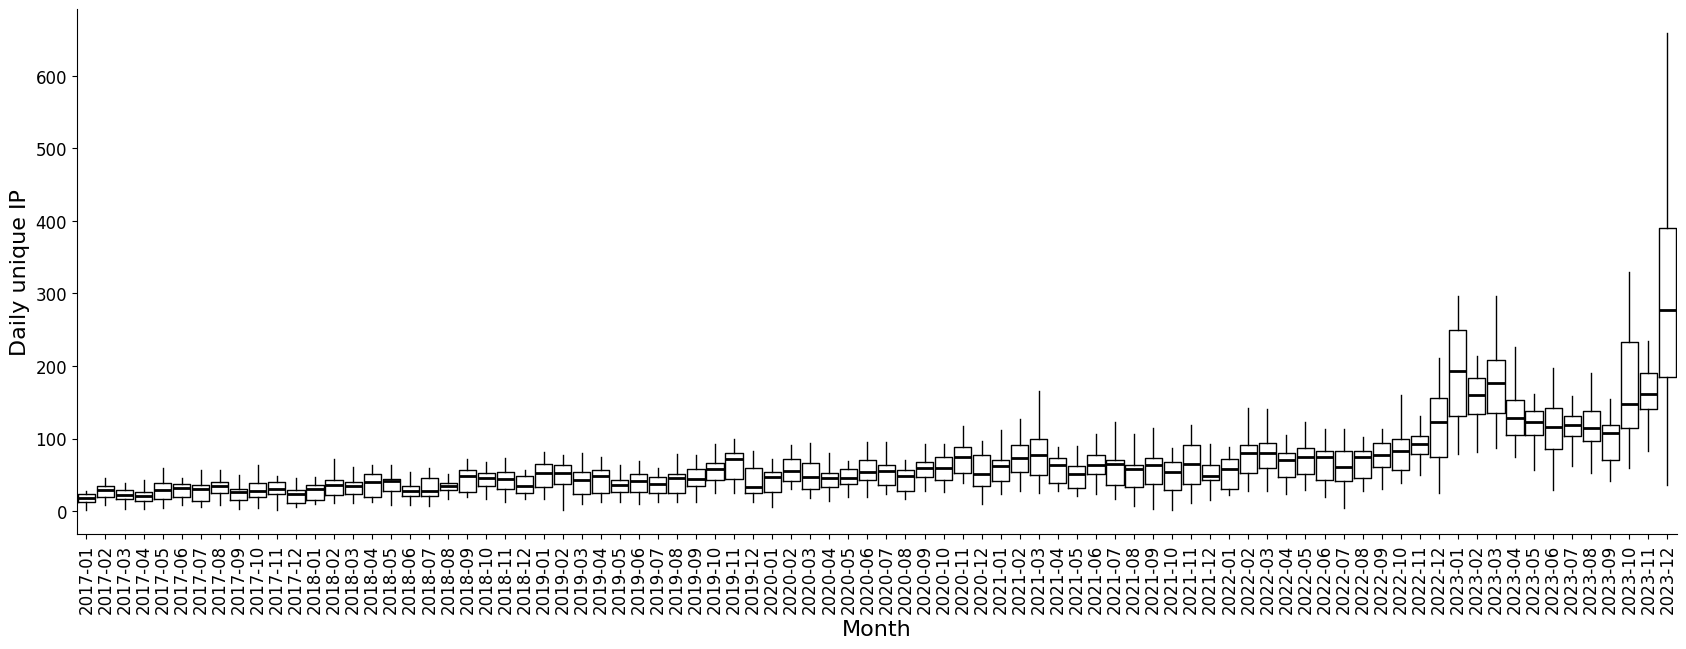

In [15]:
ax, fig=draw_box_plot(all_web_df_daily, 'unique_ip', 'month', xlabel='Month', ylabel='Daily unique IP', x_rotation=90, fig_size=(20, 7))

## Number of daily web download amount per year and month

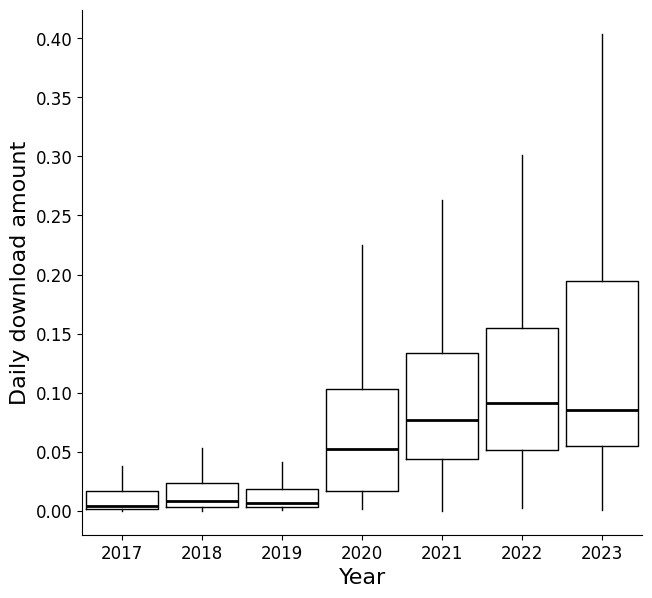

In [16]:
ax, fig=draw_box_plot(all_web_df_daily, 'bytes_out', 'year', xlabel='Year', ylabel='Daily download amount')

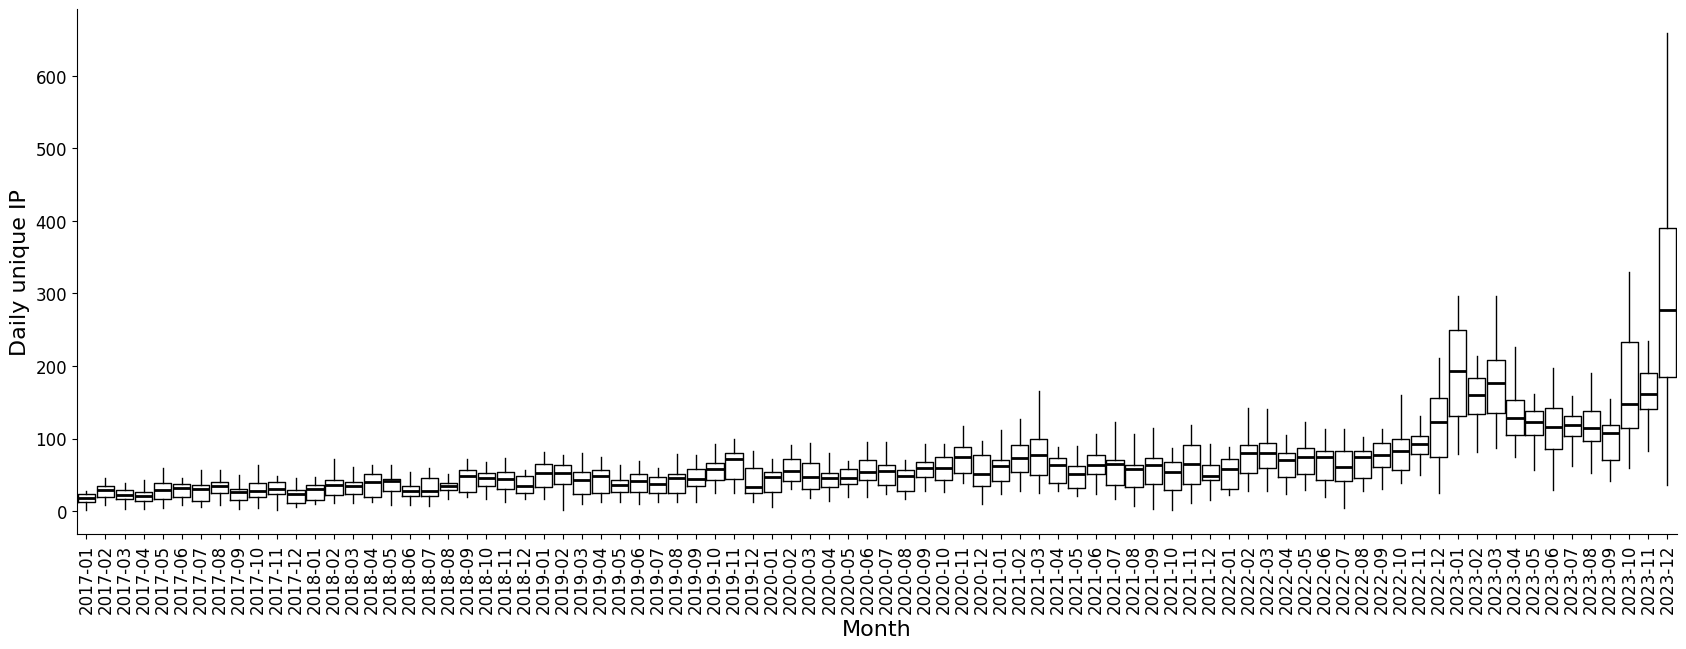

In [17]:
ax, fig=draw_box_plot(all_web_df_daily, 'unique_ip', 'month', xlabel='Month', ylabel='Daily unique IP', x_rotation=90, fig_size=(20, 7))

In [18]:
all_web_df['year']=pd.DatetimeIndex(all_web_df.request_ts).year
all_web_df['month']=pd.to_datetime(all_web_df.request_ts).dt.strftime('%Y-%m')
current_year_range = range(2017,2024)

In [19]:
all_web_df_yearly = all_web_df[all_web_df['year'].isin( current_year_range )].groupby(all_web_df.year).agg(
    bytes_out=pd.NamedAgg(column='bytes_out', aggfunc=lambda x: sum(x)/1000000000),
    unique_ip=pd.NamedAgg(column='client_ip', aggfunc='nunique'),
    nb_request=pd.NamedAgg(column='client_ip', aggfunc=lambda x: len(x)/1000000))
all_web_df_yearly.reset_index(inplace=True)
all_web_df_monthly = all_web_df[all_web_df['year'].isin( current_year_range )].groupby(all_web_df.month).agg(
    bytes_out=pd.NamedAgg(column='bytes_out', aggfunc=lambda x: sum(x)/1000000000),
    unique_ip=pd.NamedAgg(column='client_ip', aggfunc='nunique'),
    nb_request=pd.NamedAgg(column='client_ip', aggfunc=lambda x: len(x)/1000000))
all_web_df_monthly.reset_index(inplace=True)

In [20]:
all_ftp_df['year'] = pd.DatetimeIndex(all_ftp_df.event_ts).year
all_ftp_df['month']=pd.to_datetime(all_ftp_df.event_ts).dt.strftime('%Y-%m')
current_year_range = range(2017,2024)

In [21]:
all_ftp_df_yearly = all_ftp_df[all_ftp_df['year'].isin( current_year_range )].groupby(all_ftp_df.year).agg(
    file_size=pd.NamedAgg(column='file_size', aggfunc=lambda x: sum(x)/1000000000),
    uhost=pd.NamedAgg(column='uhost', aggfunc='nunique'),
    nb_request=pd.NamedAgg(column='uhost', aggfunc='count'))
all_ftp_df_yearly.reset_index(inplace=True)
all_ftp_df_monthly = all_ftp_df[all_ftp_df['year'].isin( current_year_range )].groupby(all_ftp_df.month).agg(
    file_size=pd.NamedAgg(column='file_size', aggfunc=lambda x: sum(x)/1000000000),
    uhost=pd.NamedAgg(column='uhost', aggfunc='nunique'),
    nb_request=pd.NamedAgg(column='uhost', aggfunc='count'))
all_ftp_df_monthly.reset_index(inplace=True)

In [53]:
def draw_bar_plot(dataframe, x, y, xlabel, ylabel, x_rotation=0, fig_size=(7, 7), fontsize=16):
    ax = dataframe.plot.bar(x=x, y=y, width =.9, color='k', legend=False, grid=False, fontsize=16, figsize=fig_size)
    ax.tick_params(axis='x', rotation=x_rotation)
    ax.set_facecolor('white')
    ax.set_ylabel(ylabel, fontdict={'fontsize':fontsize})
    ax.set_xlabel(xlabel, fontdict={'fontsize':fontsize})
    ax.tick_params(axis='x', labelsize=fontsize-4)
    ax.tick_params(axis='y', labelsize=fontsize-4)
    return ax

## Total Number of Gigabytes downloaded from FTP per year and month

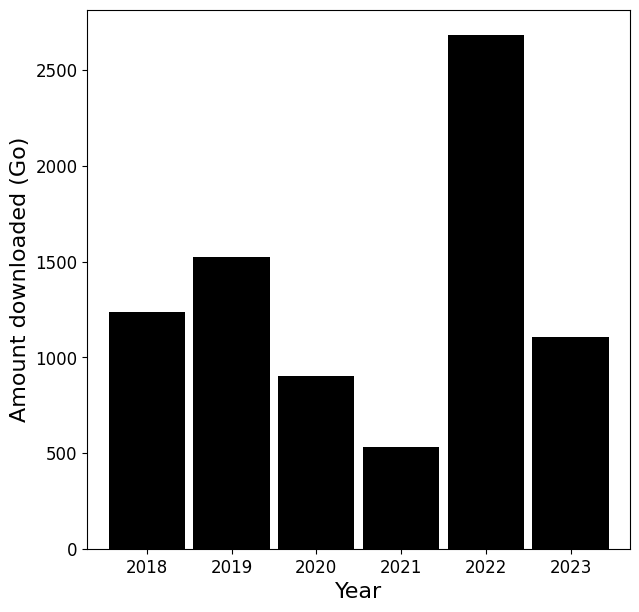

In [54]:
ax = draw_bar_plot(all_ftp_df_yearly, x='year', y='file_size', ylabel='Amount downloaded (Go)', xlabel='Year')

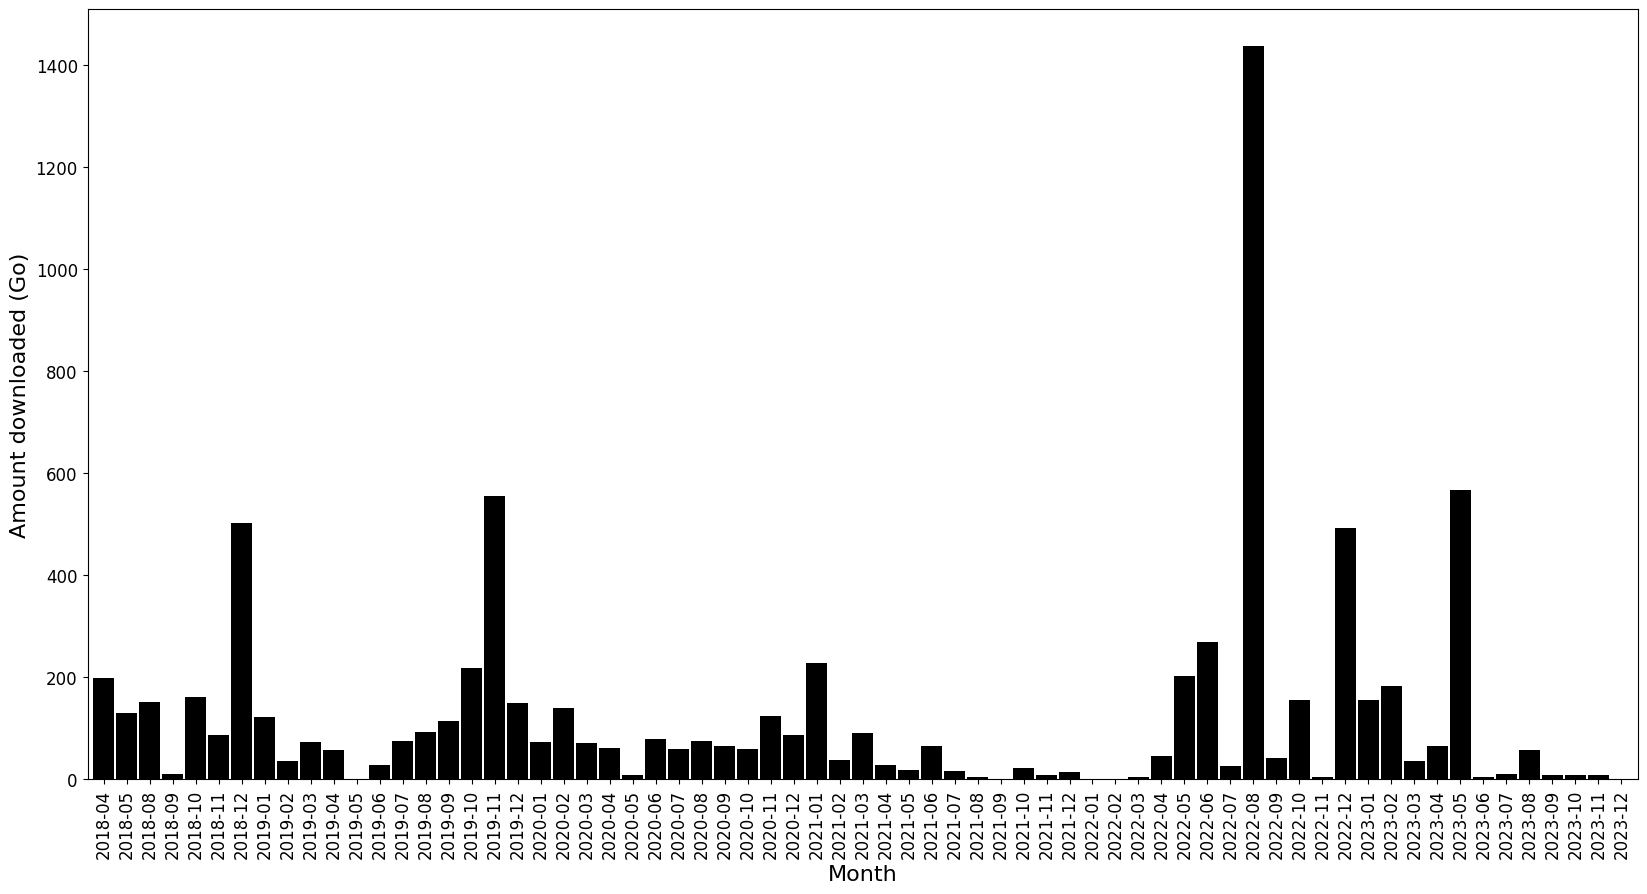

In [24]:
ax = draw_bar_plot(all_ftp_df_monthly, x='month', y='file_size', ylabel='Amount downloaded (Go)', xlabel='Month', x_rotation=90, fig_size=(20, 10))

## Total Number of unique visitor to the FTP per year and month

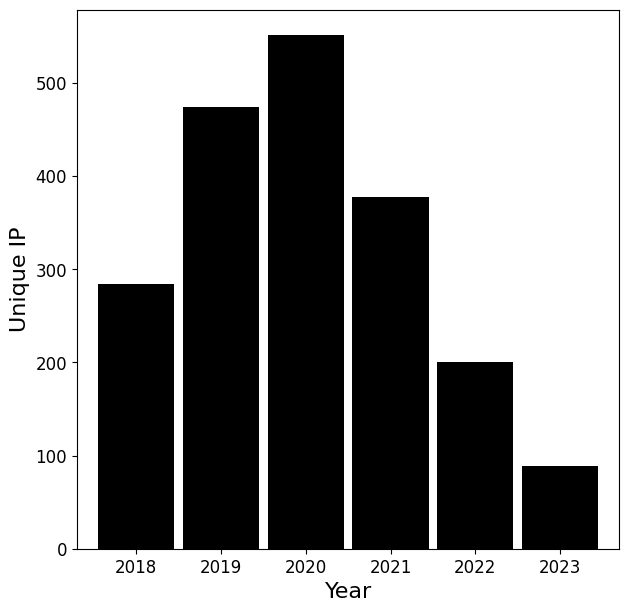

In [25]:
ax = draw_bar_plot(all_ftp_df_yearly, x='year', y='uhost', ylabel='Unique IP', xlabel='Year')

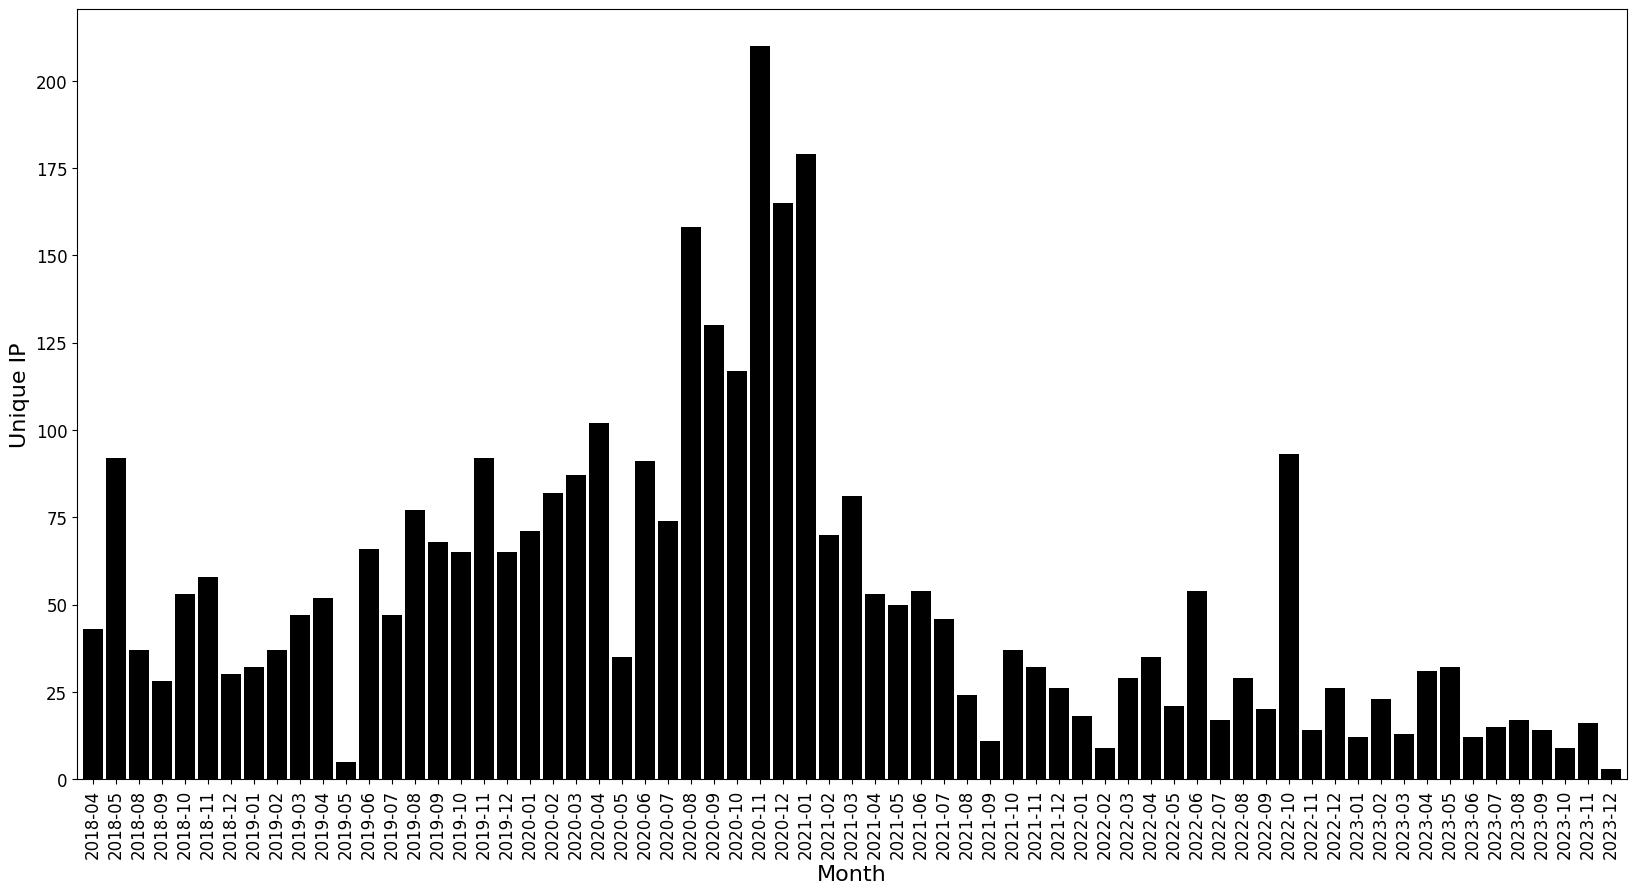

In [26]:
ax = draw_bar_plot(all_ftp_df_monthly, x='month', y='uhost', ylabel='Unique IP', xlabel='Month', x_rotation=90, fig_size=(20, 10))

## Total Number of request to the FTP per year and month

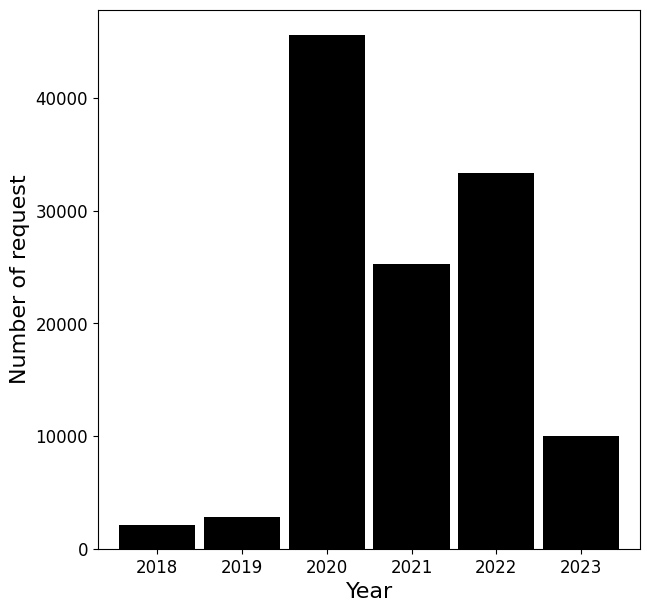

In [27]:
ax = draw_bar_plot(all_ftp_df_yearly, x='year', y='nb_request', ylabel='Number of request', xlabel='Year')

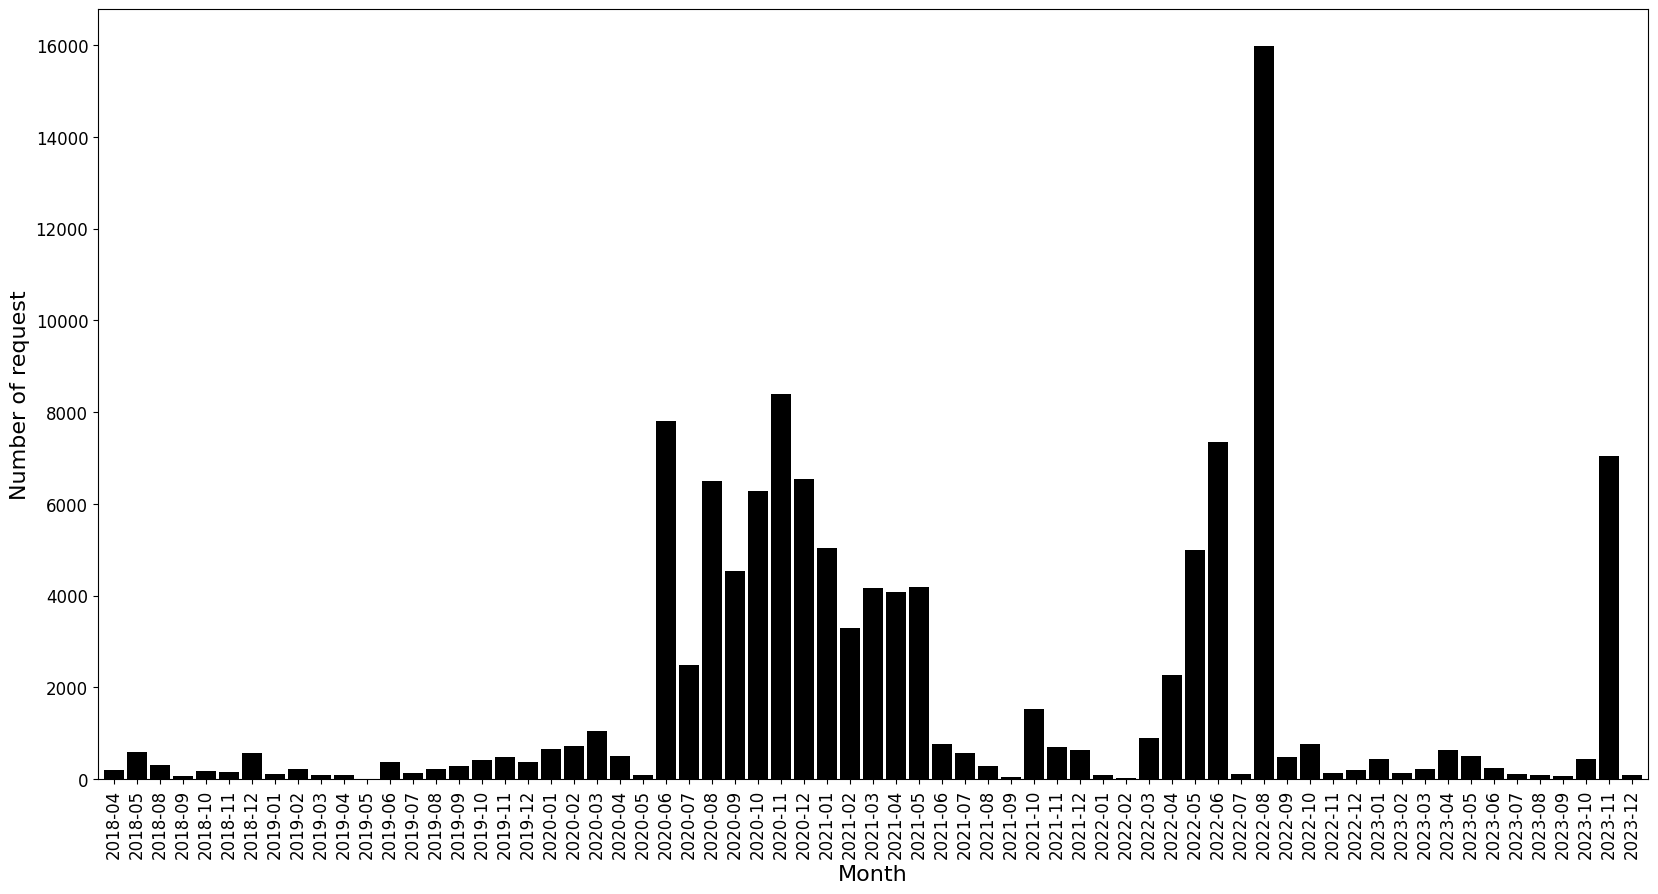

In [28]:
ax = draw_bar_plot(all_ftp_df_monthly, x='month', y='nb_request', ylabel='Number of request', xlabel='Month', x_rotation=90, fig_size=(20, 10))

## Total Number of Gigabytes downloaded from Website per year and month

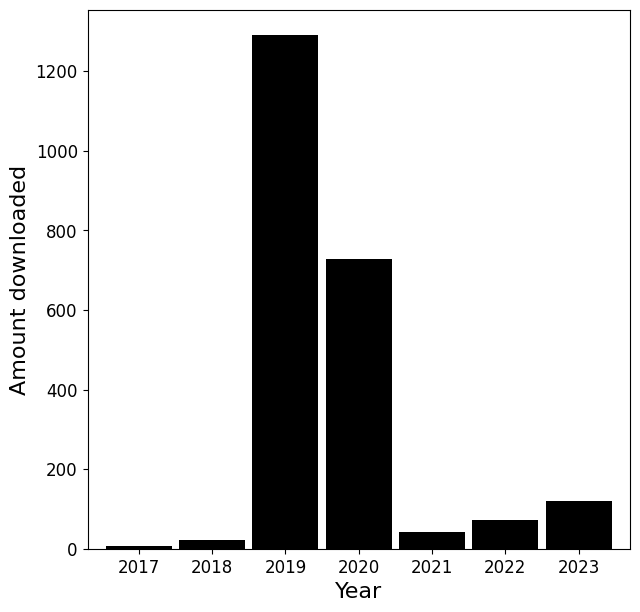

In [29]:
ax = draw_bar_plot(all_web_df_yearly, x='year', y='bytes_out', ylabel='Amount downloaded', xlabel='Year')

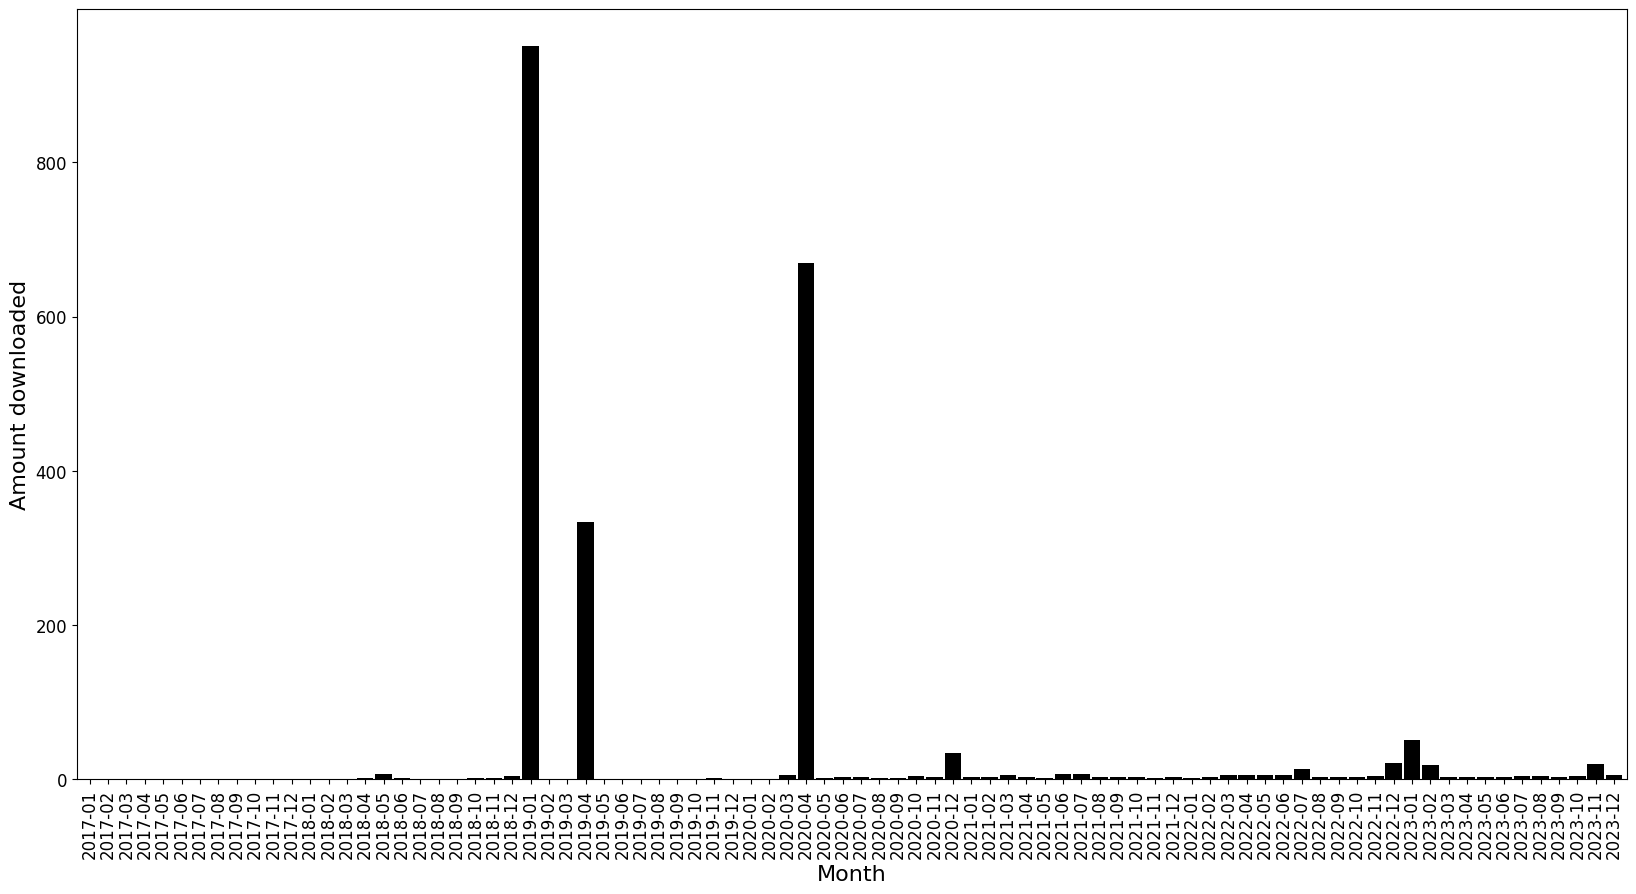

In [30]:
ax = draw_bar_plot(all_web_df_monthly, x='month', y='bytes_out', ylabel='Amount downloaded', xlabel='Month', x_rotation=90, fig_size=(20, 10))

## Total Number of unique visitor to the website per year and month

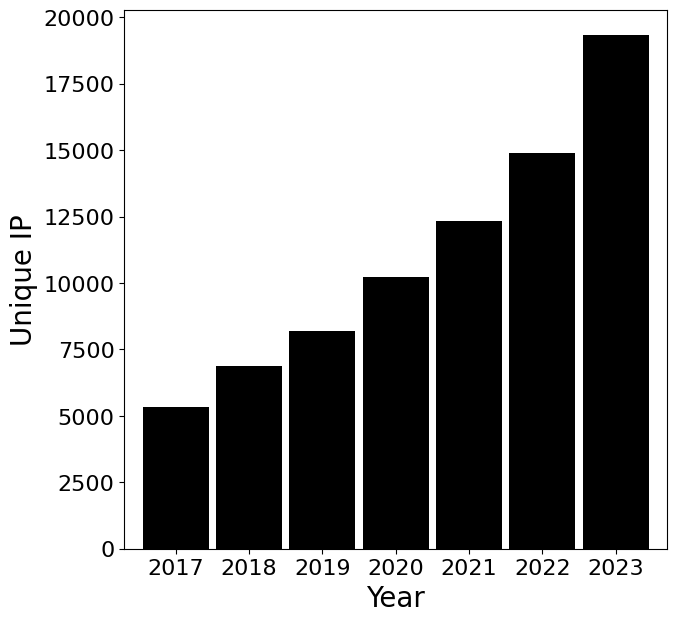

In [55]:
ax = draw_bar_plot(all_web_df_yearly, x='year', y='unique_ip', ylabel='Unique IP', xlabel='Year', fontsize=20)

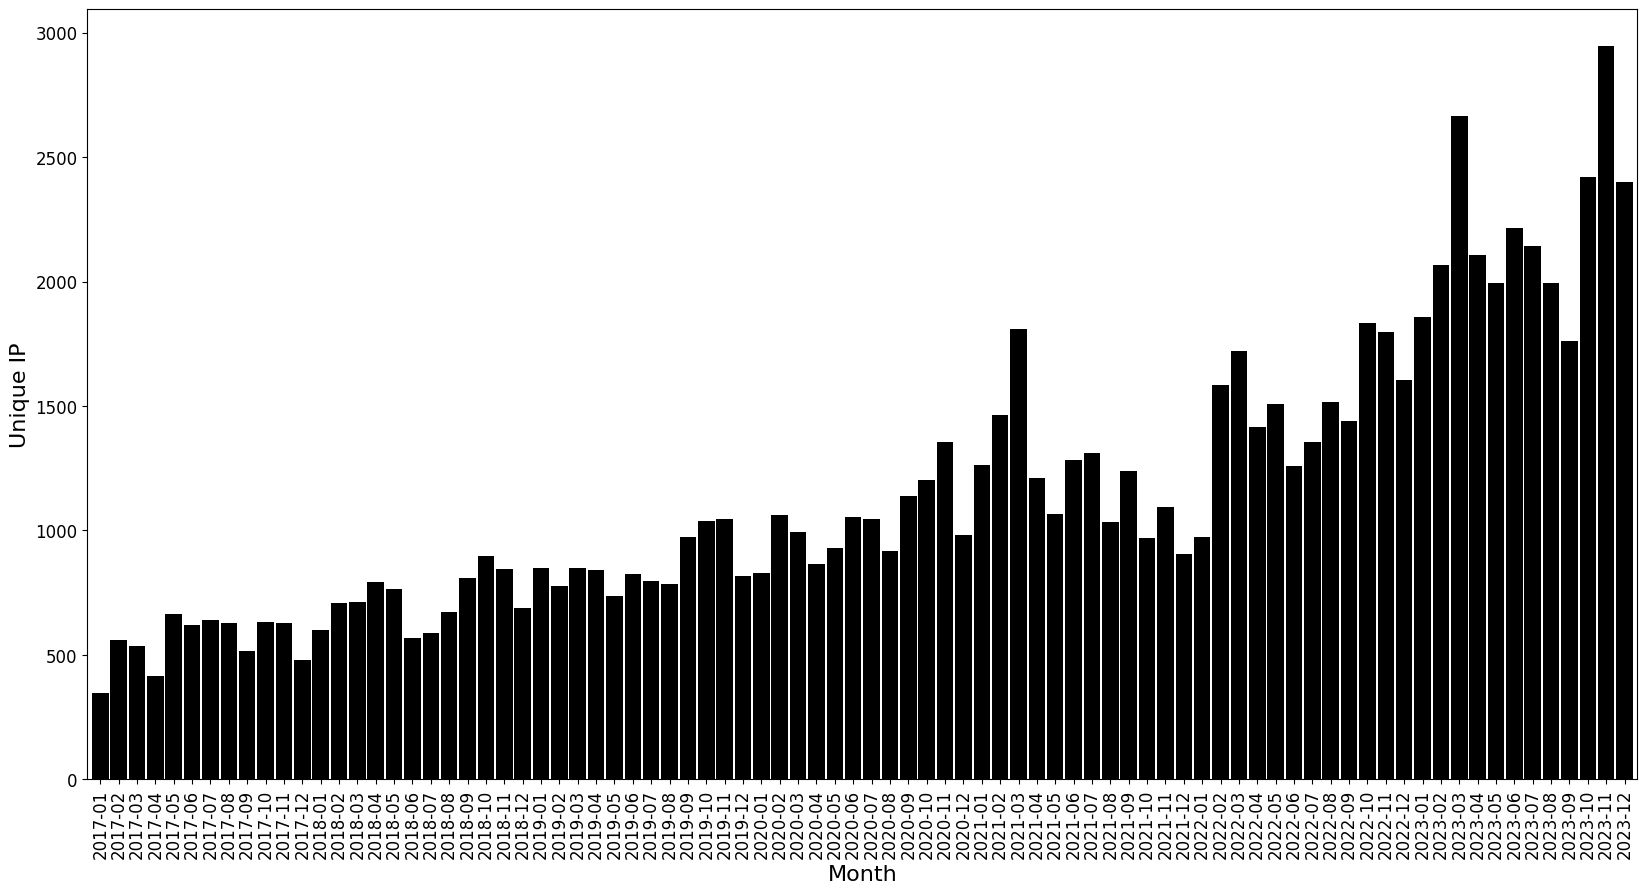

In [32]:
ax = draw_bar_plot(all_web_df_monthly, x='month', y='unique_ip', ylabel='Unique IP', xlabel='Month', x_rotation=90, fig_size=(20, 10))

## Total Number of request to the website per year and month

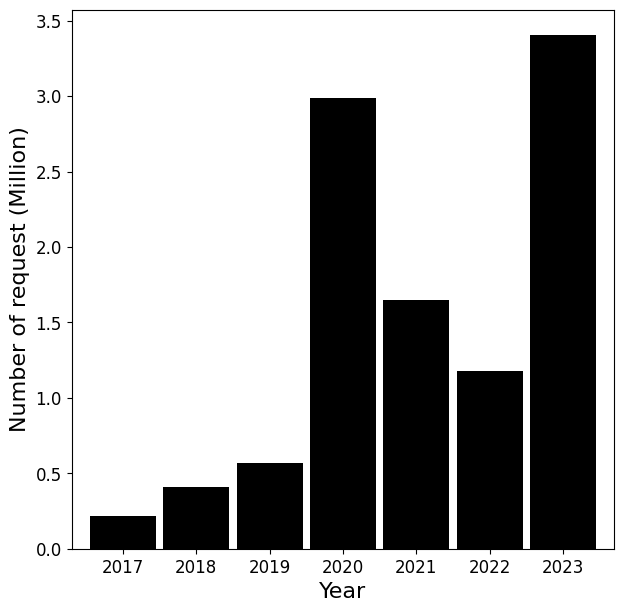

In [33]:
ax = draw_bar_plot(all_web_df_yearly, x='year', y='nb_request', ylabel='Number of request (Million)', xlabel='Year')

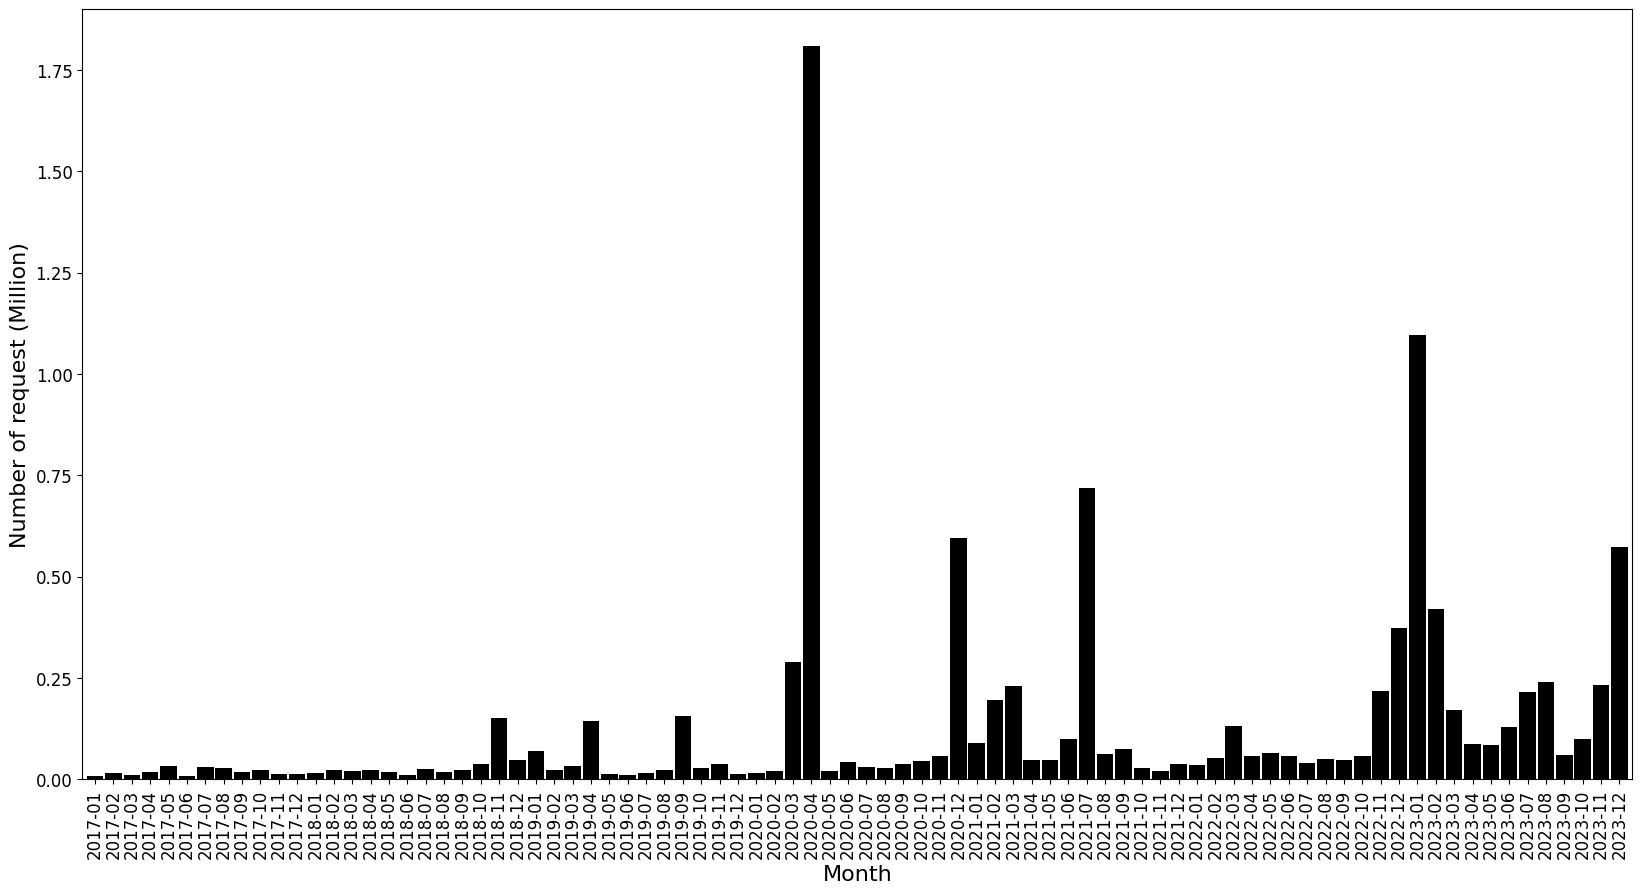

In [34]:
ax = draw_bar_plot(all_web_df_monthly, x='month', y='nb_request', ylabel='Number of request (Million)', xlabel='Month', x_rotation=90, fig_size=(20, 10))

# Location of EVA downloads from API in 2023
## Connection to EVA

In [35]:
# This is to cache the IP -> location until we had this to the database itself
cache_file = 'cache.json'
if os.path.isfile(cache_file):
    with open(cache_file) as open_file:
        cache = json.load(open_file)
else:
    cache={}

def _get_location(ip_address):
    response = requests.get('https://geolocation-db.com/json/' + ip_address)
    response.raise_for_status()
    return response.json()

def get_location(ip_address):
    if ip_address not in cache:
        try:
            cache[ip_address] = _get_location(ip_address)
        except HTTPError:
            cache[ip_address] = {}
    return cache[ip_address]


In [36]:
web_df_2023 = all_web_df[(all_web_df['request_ts'] > '2023-01-01') & (all_web_df['request_ts'] < '2024-01-01')]
web_df_2023['client_ip'].unique()
res = web_df_2023.apply(lambda row: get_location(row.client_ip), axis='columns', result_type='expand')
with open(cache_file, 'w') as open_file:
    json.dump(cache, open_file)

## IP addresses connected to EVA in 2023 as scatter

/var/folders/y1/frdbbq352hz40j4scyzb_pjm0000gp/T/ipykernel_15578/381472753.py:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


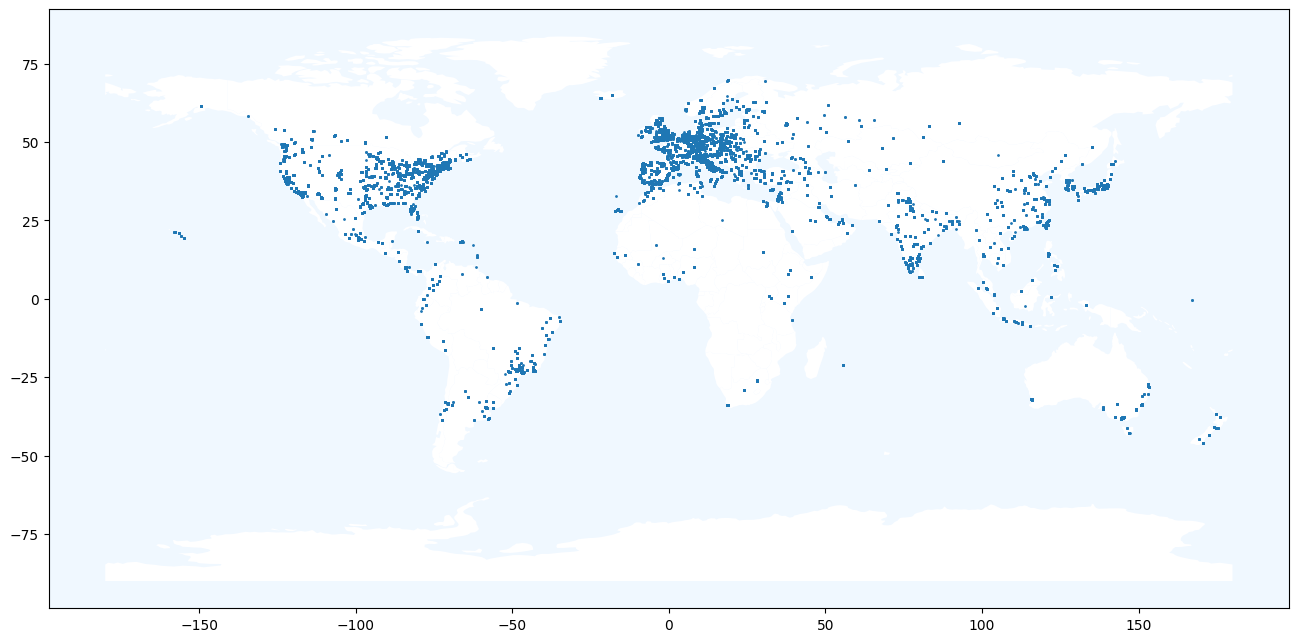

In [37]:
res = res[res.latitude!='Not found']

import geopandas as gpd

# Read the map
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
# Plot the map
ax = countries.plot(color="white", figsize=(16,16))
# Plot the position of the IP addresses
ax.scatter(res["longitude"], res["latitude"], s=1)
ax.grid(False)
ax.set_facecolor("aliceblue")


## IP addresses connected to EVA per country in 2023 (Log scale)

/var/folders/y1/frdbbq352hz40j4scyzb_pjm0000gp/T/ipykernel_15578/3004535183.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


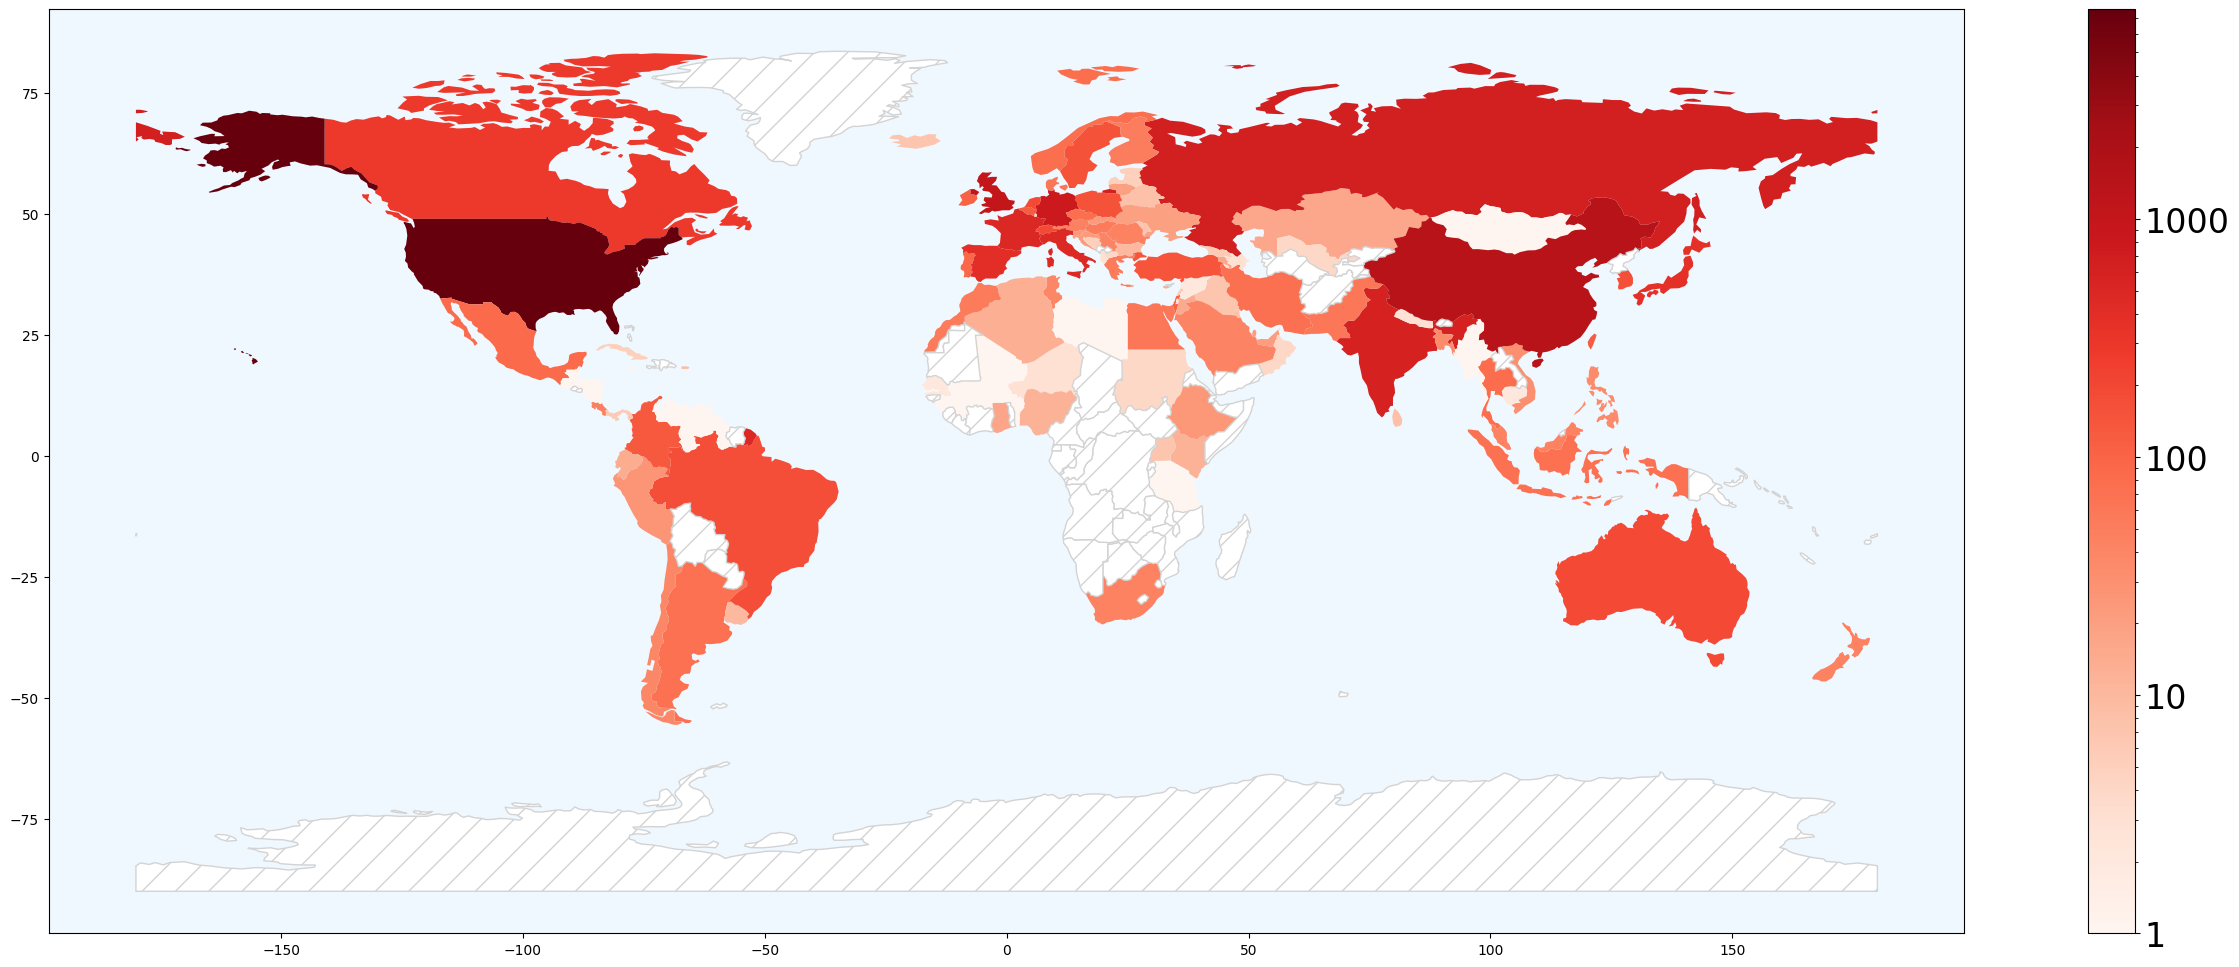

In [38]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#Plot the map
map_country_code = pd.read_csv('map_country_code.csv')

count_per_country = res.groupby(['country_code'])[['IPv4']].nunique()

count_per_country_with_code = count_per_country.merge(map_country_code, how='left', left_on='country_code', right_on='Alpha-2 code')

count_in_world = world.merge(count_per_country_with_code, how='outer', left_on='iso_a3', right_on='Alpha-3 code')
ax = count_in_world.plot(column='IPv4', legend=True, cmap=matplotlib.colormaps['Reds'], figsize=(32, 12),
                         norm=matplotlib.colors.LogNorm(),
                        missing_kwds={
                            "color": "white",
                            "edgecolor": "lightgrey",
                            "hatch": "/",
                            "label": "Missing values",
                         })
ax.grid(False)
ax.set_facecolor("aliceblue")
fig = ax.figure
cb_ax = fig.axes[1]
cb_ax.set_yticks(ticks=[1,10,100,1000], labels=['1','10','100', '1000'])
cb_ax.tick_params(labelsize=24)